# Setup Package

In [1]:
import torch as t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt, seaborn as sns
import missingno as msno

# Data Visualizaton

## ETTm2

In [2]:
df_ettm2=pd.read_csv("Data/ETTm2.csv")

### Cetak Missing Value

<Axes: >

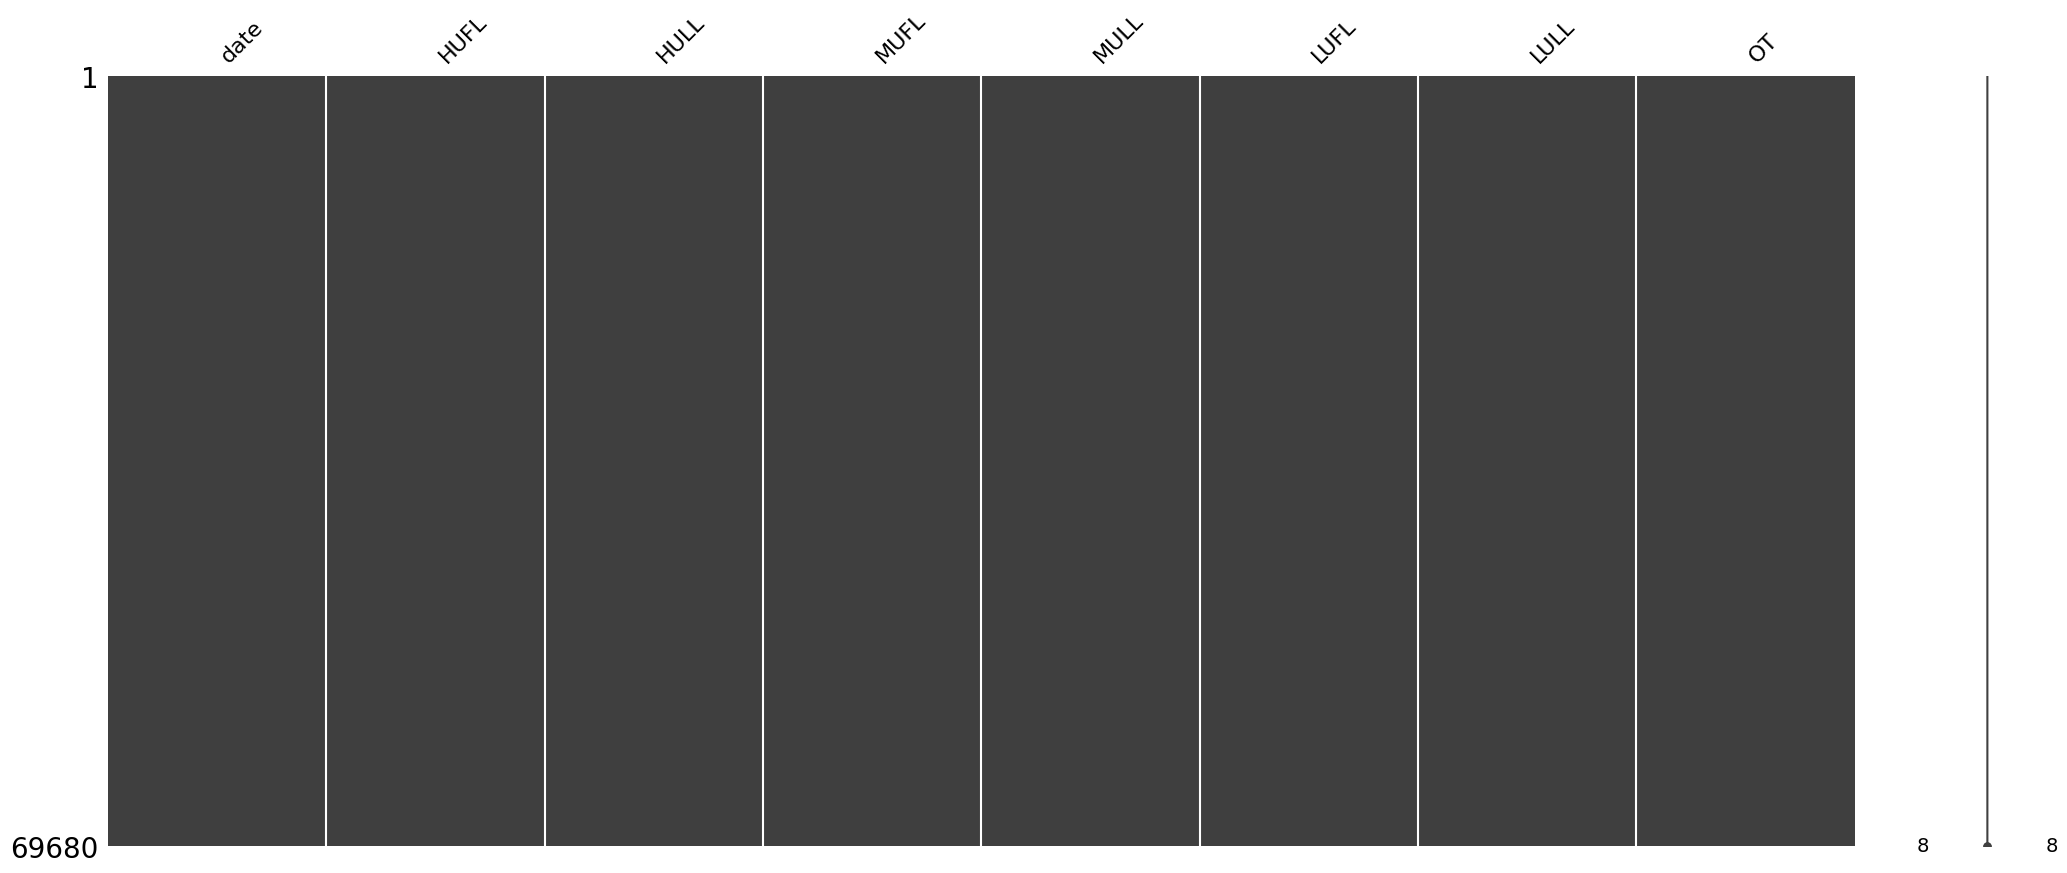

In [3]:
msno.matrix(df_ettm2)

### Cetak Korelasi

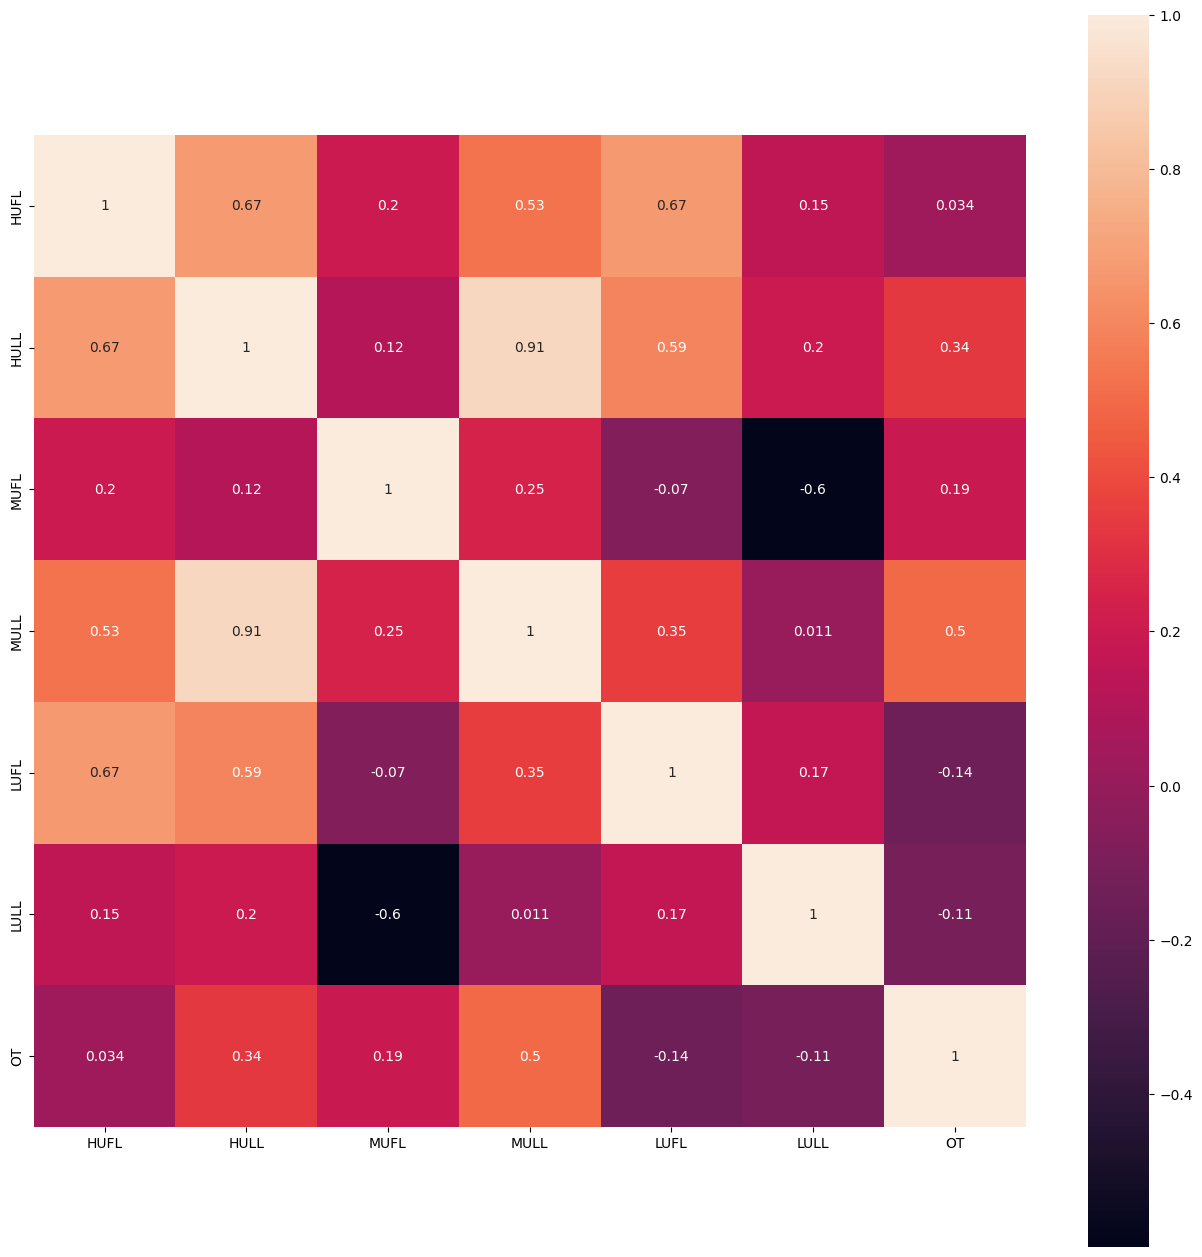

In [4]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df_ettm2.corr(numeric_only = True), annot=True, square=True)
plt.show()

### Cetak Grafik

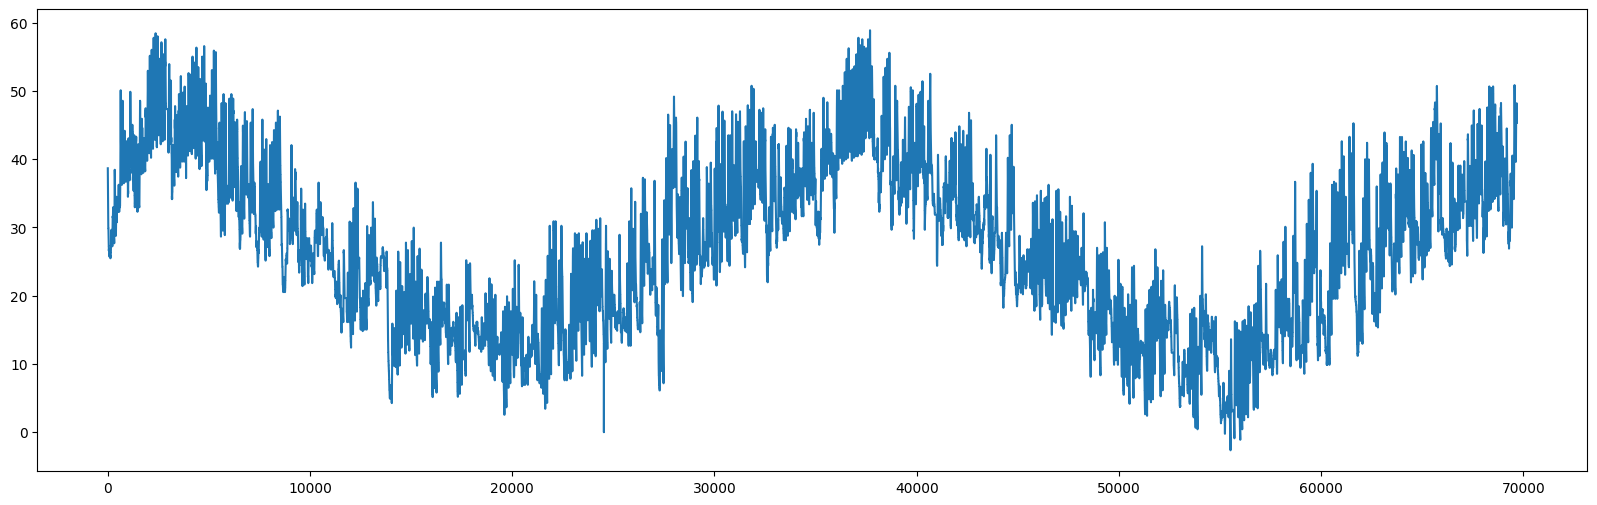

In [5]:
plt.figure(figsize=(20,6))
plt.plot(df_ettm2["OT"].to_numpy())

## Turbine Dataset

In [6]:
df_turbine=pd.read_csv("Data/Turbine_Data.csv")

### Cetak Missing Value

<Axes: >

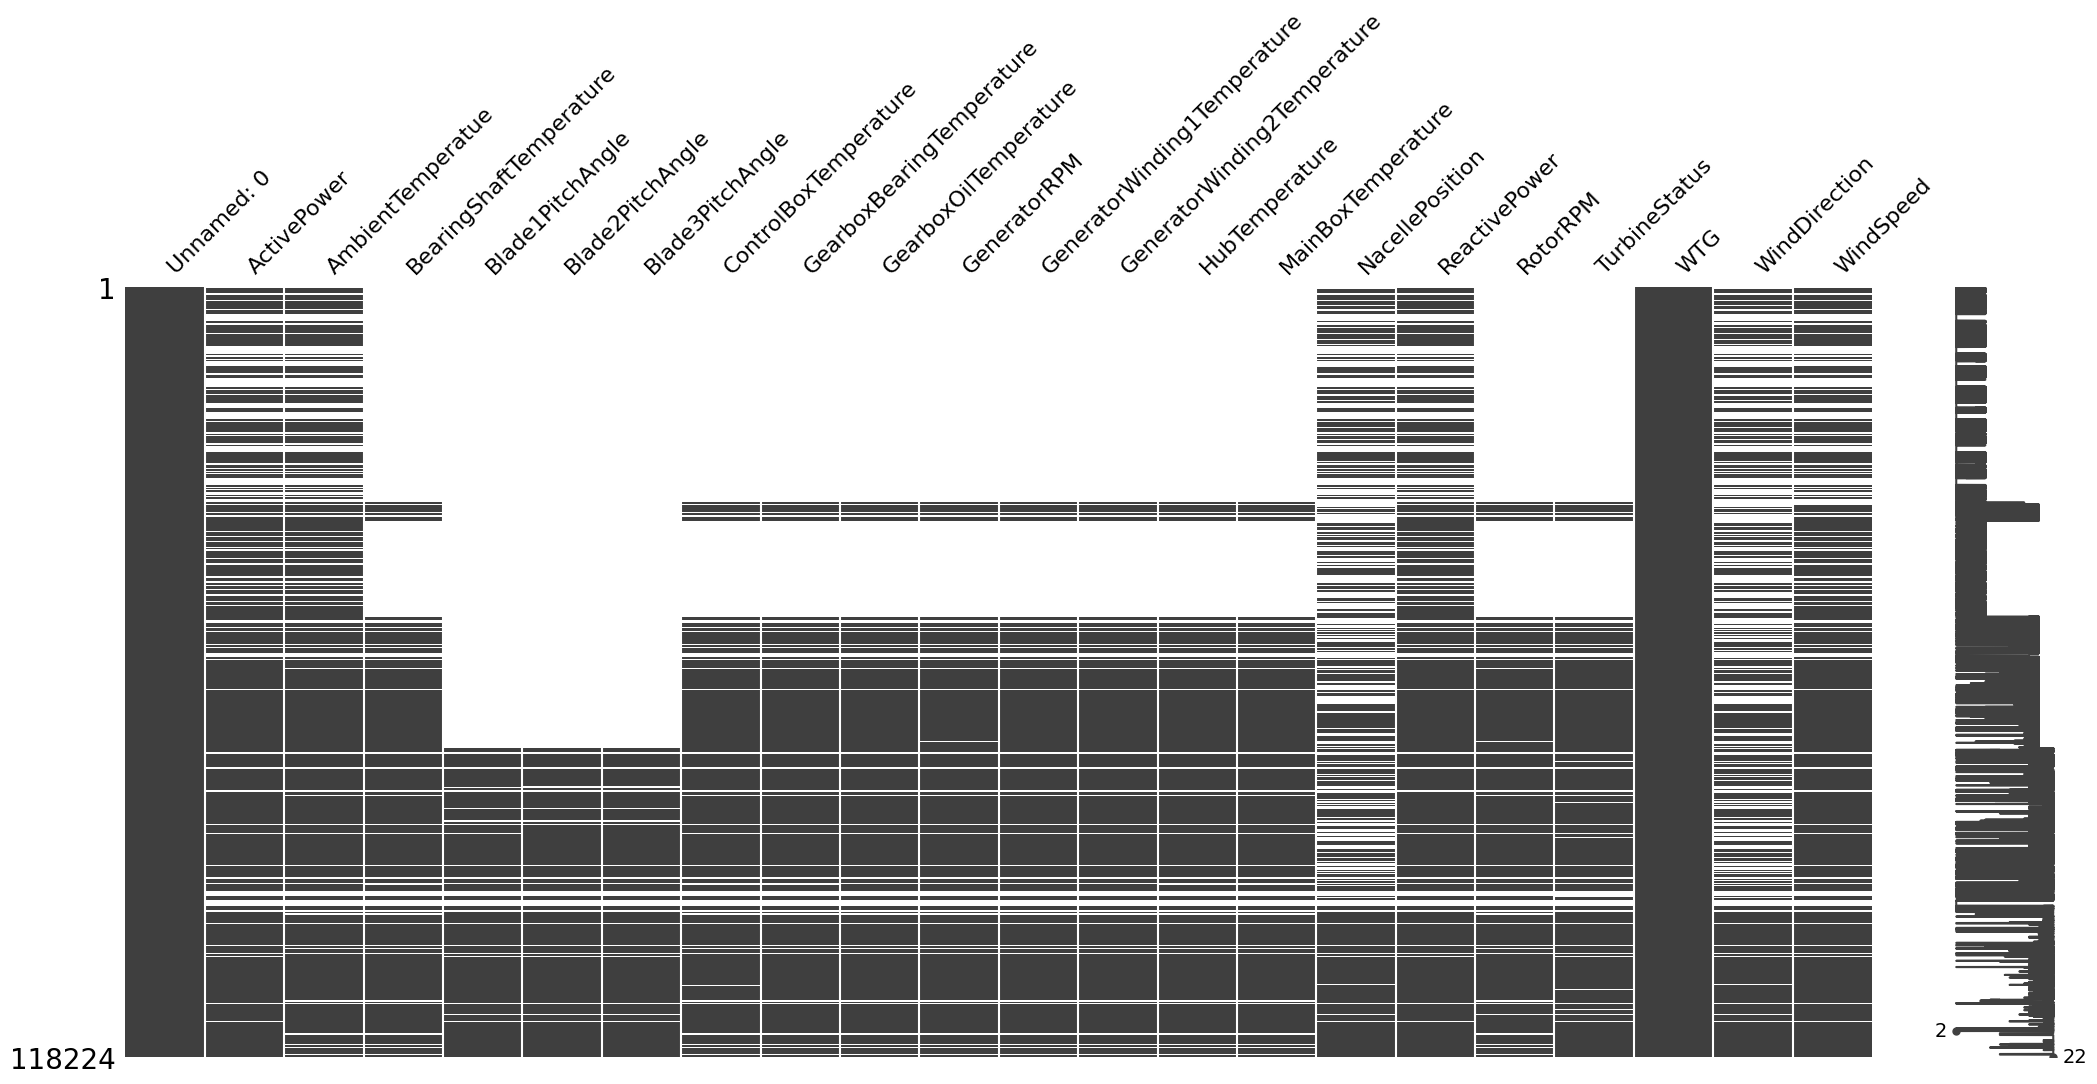

In [7]:
#the dataset shows 118224 observations for 22 features but some of the features have significant periods of missing data. We need to discard some periods and fill in the missing periods, otherwise our LSTM model will not converge or we may end up feeding it with garbage data.
#the rightmost part of the msno matrix plot shows completess of data, it indicates that the last half of dataset is more complete. We will strive to use this part for training and testing.
msno.matrix(df_turbine)

### Cek Korelasi

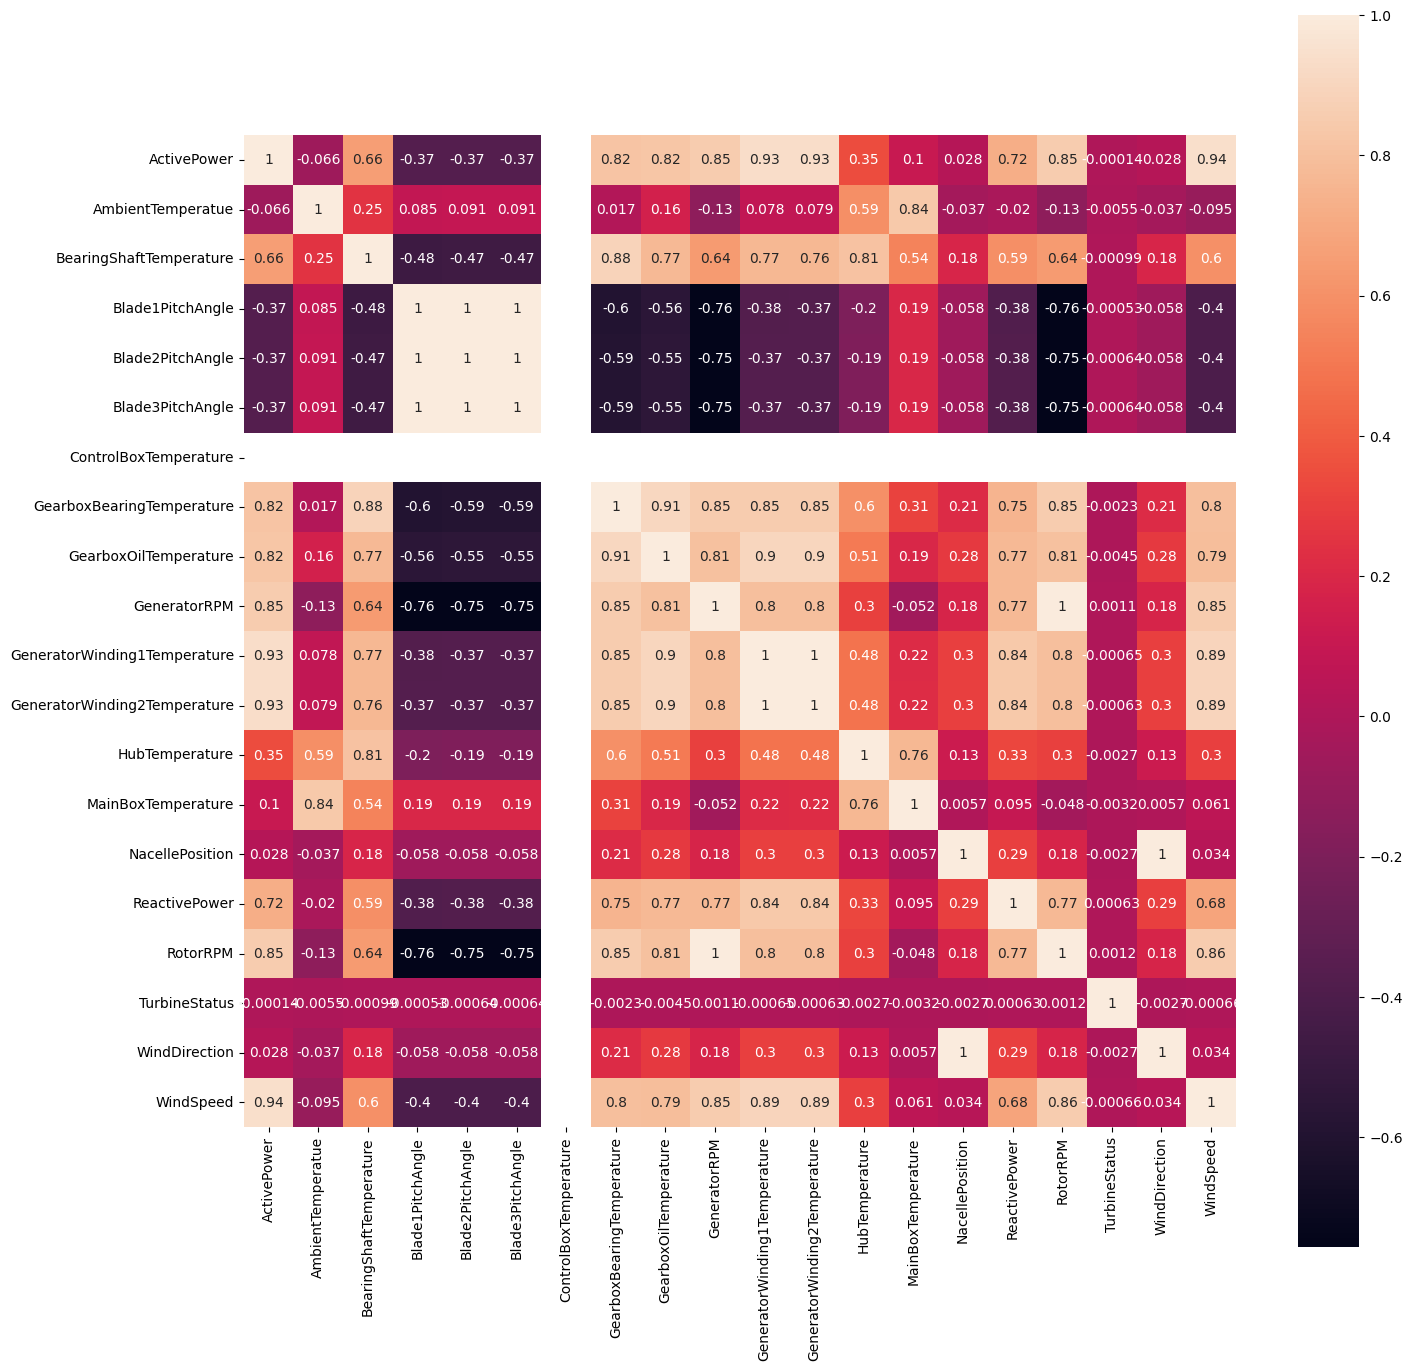

In [8]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df_turbine.corr(numeric_only = True), annot=True, square=True)
plt.show()

Terdapat 2 data yang berkorelasi kuat:
- Windspeed 
- ActivePower

### Cetak Grafik

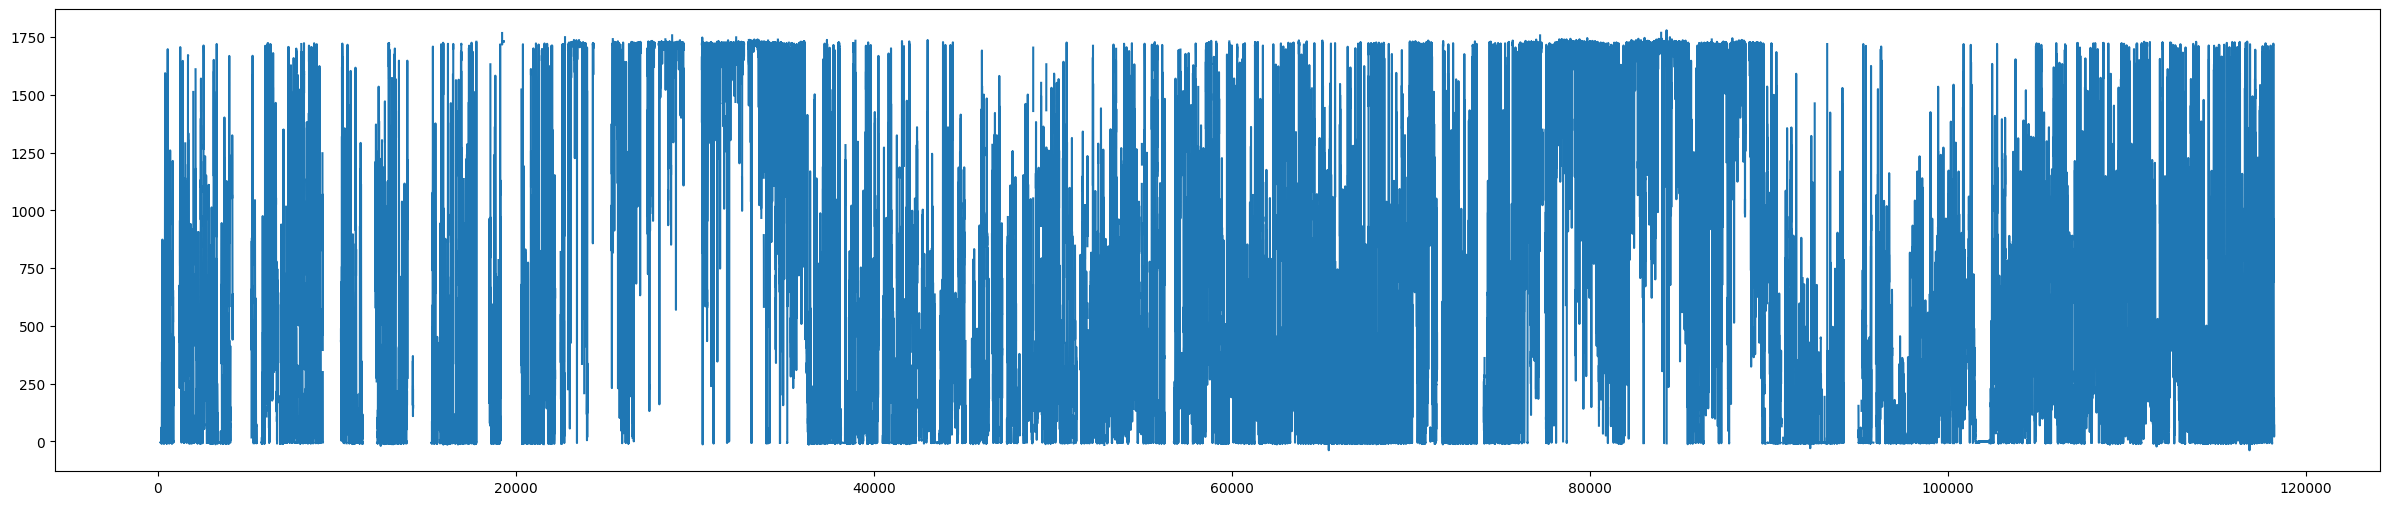

In [9]:
plt.figure(figsize=(30,6))
plt.plot(df_turbine["ActivePower"].to_numpy())

## M4 Dataset

In [523]:
df_m4=pd.read_csv("Data/m4/Daily-train.csv")

In [524]:
df_m4=df_m4.iloc[:, 0:10]

In [525]:
df_m4.shape

(4227, 10)

### Cetak Missing Value

<Axes: >

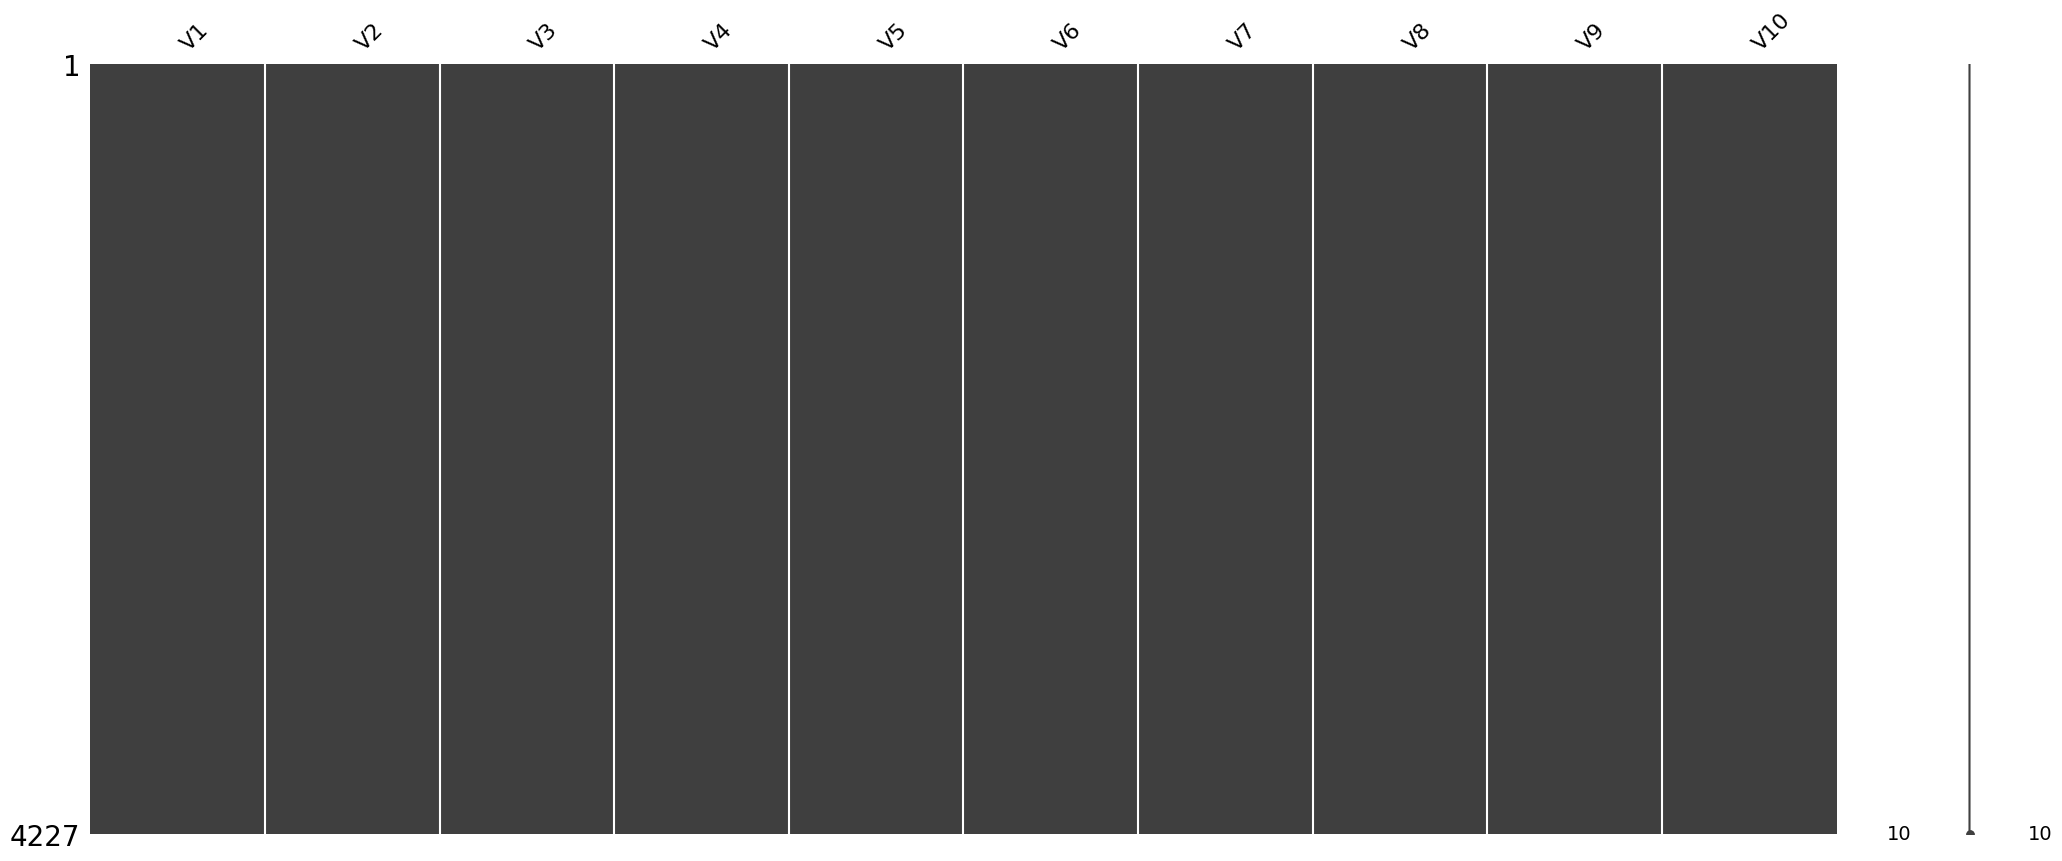

In [526]:
msno.matrix(df_m4)

### Cetak Korelasi

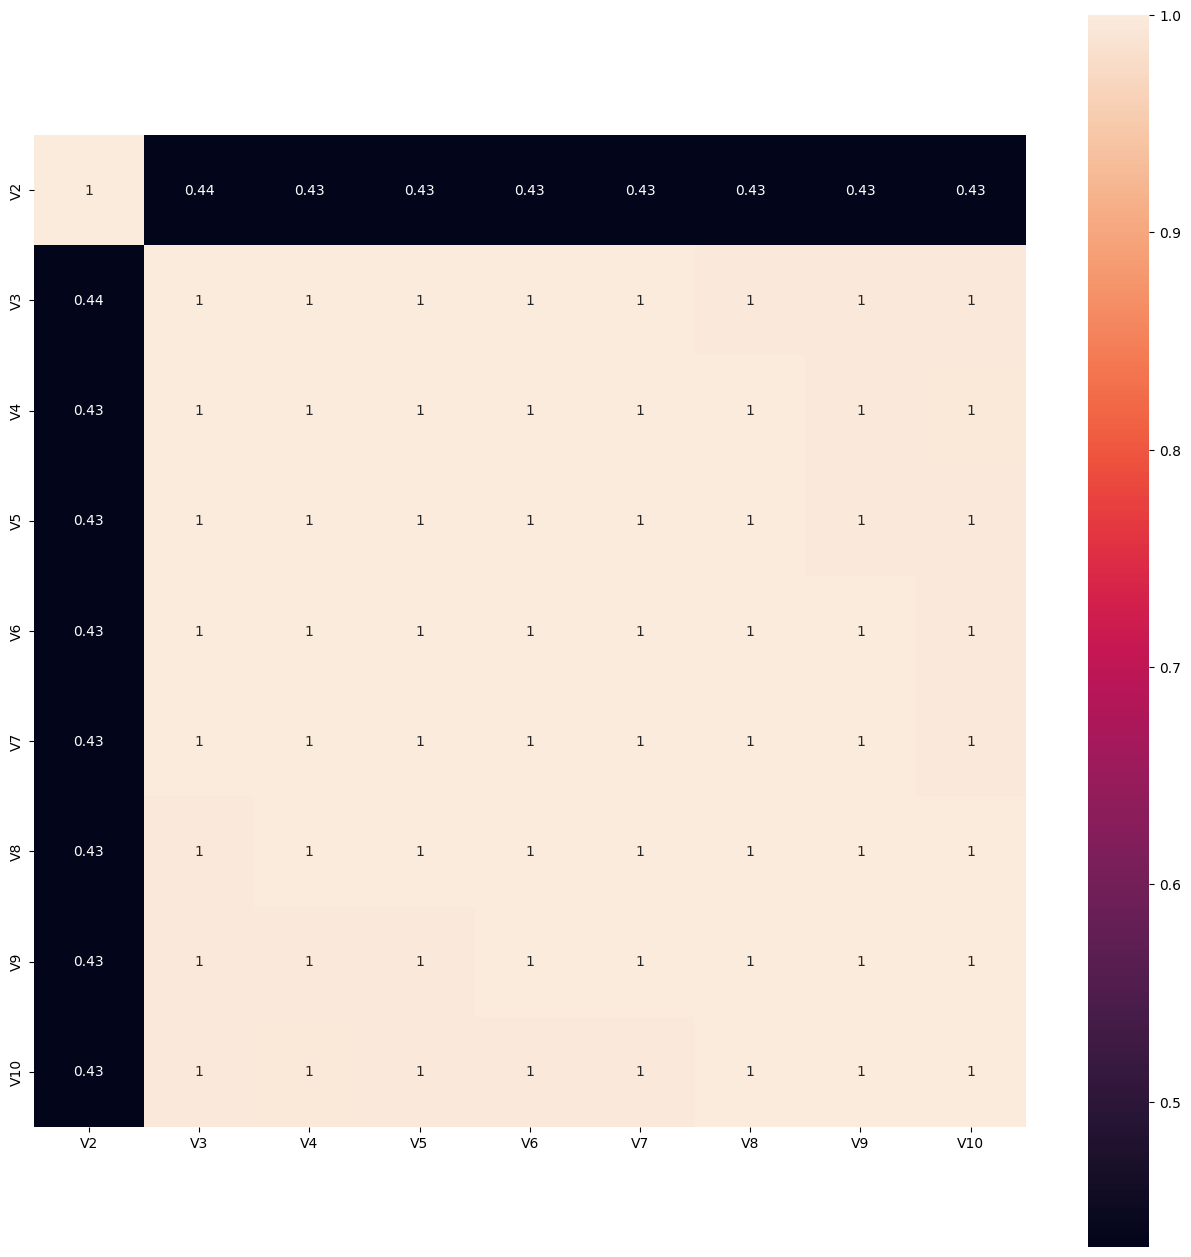

In [527]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df_m4.corr(numeric_only = True), annot=True, square=True)
plt.show()

### Cetak grafik

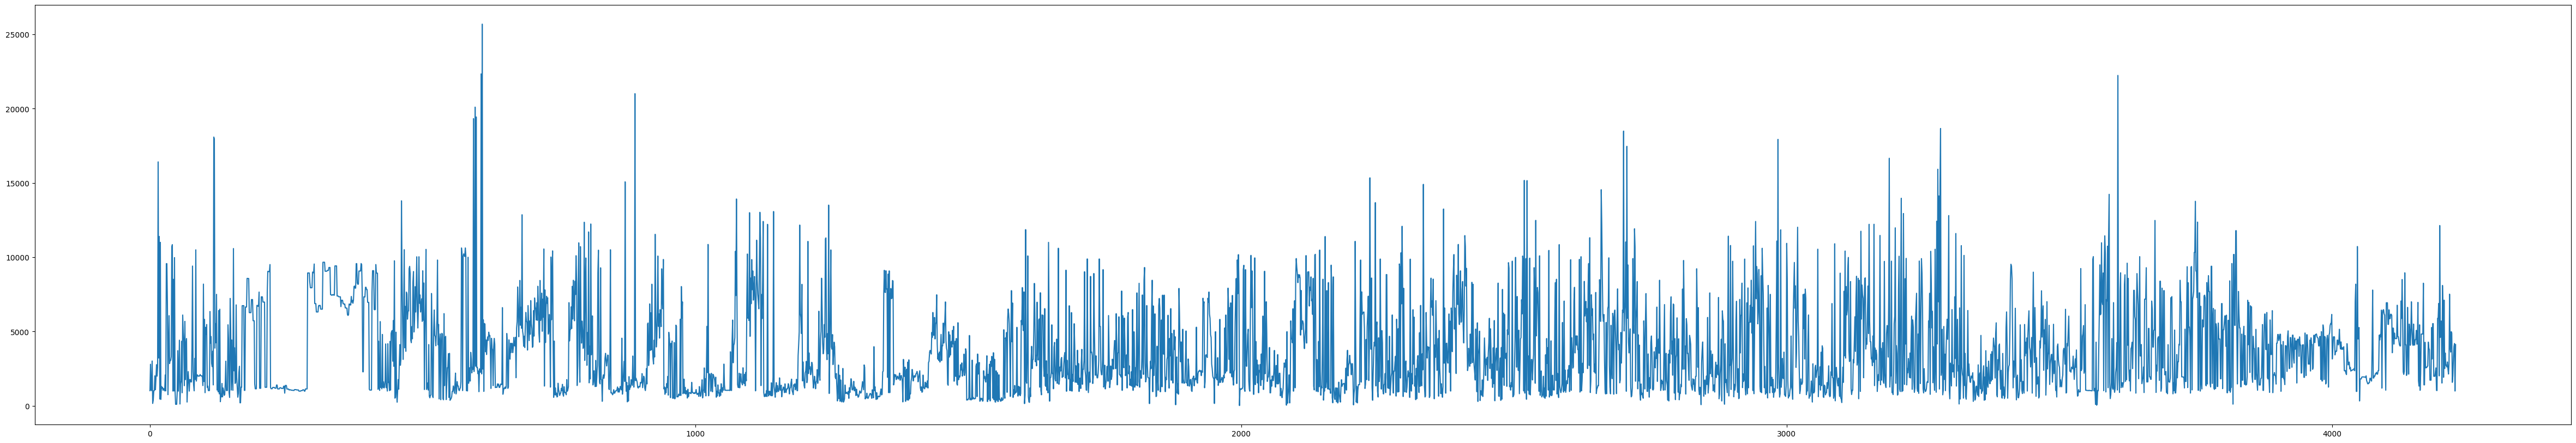

In [664]:
plt.figure(figsize=(60,10))
plt.plot(df_m4["V7"].to_numpy())

In [665]:
df_m4["V2"]

0         1017.10
1         2793.70
2         1091.30
3         1092.00
4         2938.63
          ...    
4222     10000.00
4223     10000.00
4224    352000.00
4225       994.16
4226      4159.10
Name: V2, Length: 4227, dtype: float64

# Manualisasi Hitungan

Semua model yang ada disini seluruhnya bergantung pada model dibawah
![Alt text](image.png)

In [666]:
import torch
import torch.nn as nn

In [667]:
input_manual=df_m4["V2"][:7].to_numpy()
input_manual

array([1017.1   , 2793.7   , 1091.3   , 1092.    , 2938.63  ,  153.7315,
        131.628 ])

## Normalisasi

In [668]:
from sklearn.preprocessing import MinMaxScaler
 
scaler=MinMaxScaler(feature_range=(-1,1))
normalized_manual=scaler.fit_transform(input_manual.reshape(-1, 1))
# normalized_manual=normalized_manual.flatten()
normalized_manual

array([[-0.36909771],
       [ 0.8967368 ],
       [-0.31622991],
       [-0.31573116],
       [ 1.        ],
       [-0.98425117],
       [-1.        ]])

In [669]:

input_pd=pd.DataFrame(normalized_manual)
input_pd.to_csv("data_manual.csv",index=False)

In [670]:
x=normalized_manual[:5]
y=normalized_manual[4:6]
target=normalized_manual[5::]

## Pre Layer

In [671]:
import numpy as np
def PreLayerX(input,dmodel):
    np.random.seed(100)
    Wx = np.random.uniform(-1, 1, (1,dmodel))
    Bx = np.random.uniform(-1, 1, (1,dmodel))
    result=np.dot(input,Wx)+Bx
    # result=(input*Wx)+Bx
    return result
def PreLayerY(input,dmodel):
    np.random.seed(101)
    Wy = np.random.uniform(-1, 1, (1,dmodel))
    By = np.random.uniform(-1, 1, (1,dmodel))
    By= np.array([1,2,3,4])
    result=np.dot(input,Wy)+By
    # result=(input*Wx)+Bx
    return result
PrX=PreLayerX(x,4)
PrY=PreLayerY(y,4)
print(PrX.shape,PrX)
print(PrY.shape, PrY)



(5, 4) [[-1.02260362 -0.59325506  0.39721894  0.39719335]
 [-0.91271667 -1.15435042  0.20612246  1.2700524 ]
 [-1.01801417 -0.6166893   0.38923776  0.43364846]
 [-1.01797087 -0.61691038  0.38916247  0.43399237]
 [-0.9037524  -1.20012299  0.19053335  1.34125777]]
(2, 4) [[1.03279726 2.14133517 2.05694845 3.34304331]
 [0.96771926 1.86089069 3.92819959 4.64661039]]


## Positional Encoding

In [672]:
def positional_encoding(max_len, d_model):
    position = np.arange(0, max_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((max_len, d_model))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    return pos_enc

# Contoh penggunaan
d_model = 4
pos_encoding_x = positional_encoding(5, d_model)
pos_encoding_y = positional_encoding(2, d_model)
print(pos_encoding_x)
print(pos_encoding_y)


[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.00999983  0.99995   ]
 [ 0.90929743 -0.41614684  0.01999867  0.99980001]
 [ 0.14112001 -0.9899925   0.0299955   0.99955003]
 [-0.7568025  -0.65364362  0.03998933  0.99920011]]
[[0.         1.         0.         1.        ]
 [0.84147098 0.54030231 0.00999983 0.99995   ]]


In [673]:
print("print positional encoding for x")
print(PrX)
print(pos_encoding_x)
x_encoded=PrX+pos_encoding_x
print("hasil x_encoded")
print(x_encoded)

print positional encoding for x
[[-1.02260362 -0.59325506  0.39721894  0.39719335]
 [-0.91271667 -1.15435042  0.20612246  1.2700524 ]
 [-1.01801417 -0.6166893   0.38923776  0.43364846]
 [-1.01797087 -0.61691038  0.38916247  0.43399237]
 [-0.9037524  -1.20012299  0.19053335  1.34125777]]
[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.00999983  0.99995   ]
 [ 0.90929743 -0.41614684  0.01999867  0.99980001]
 [ 0.14112001 -0.9899925   0.0299955   0.99955003]
 [-0.7568025  -0.65364362  0.03998933  0.99920011]]
hasil x_encoded
[[-1.02260362  0.40674494  0.39721894  1.39719335]
 [-0.07124569 -0.61404811  0.21612229  2.2700024 ]
 [-0.10871674 -1.03283613  0.40923643  1.43344846]
 [-0.87685086 -1.60690287  0.41915797  1.43354241]
 [-1.6605549  -1.85376661  0.23052269  2.34045788]]


In [674]:
print("print positional encoding for y")
print(PrY)
print(pos_encoding_y)
y_encoded=PrY+pos_encoding_y
print("hasil y_encoded")
print(y_encoded)

print positional encoding for y
[[1.03279726 2.14133517 2.05694845 3.34304331]
 [0.96771926 1.86089069 3.92819959 4.64661039]]
[[0.         1.         0.         1.        ]
 [0.84147098 0.54030231 0.00999983 0.99995   ]]
hasil y_encoded
[[1.03279726 3.14133517 2.05694845 4.34304331]
 [1.80919025 2.401193   3.93819942 5.64656039]]


### Attention

In [675]:
np.random.seed(42)
QVK = np.random.uniform(-1, 1, (12, 4))
bias = np.random.uniform(-1, 1, (12, 1))
print("qvk")
print(QVK)
print("bias")
print(bias)

qvk
[[-0.25091976  0.90142861  0.46398788  0.19731697]
 [-0.68796272 -0.68801096 -0.88383278  0.73235229]
 [ 0.20223002  0.41614516 -0.95883101  0.9398197 ]
 [ 0.66488528 -0.57532178 -0.63635007 -0.63319098]
 [-0.39151551  0.04951286 -0.13610996 -0.41754172]
 [ 0.22370579 -0.72101228 -0.4157107  -0.26727631]
 [-0.08786003  0.57035192 -0.60065244  0.02846888]
 [ 0.18482914 -0.90709917  0.2150897  -0.65895175]
 [-0.86989681  0.89777107  0.93126407  0.6167947 ]
 [-0.39077246 -0.80465577  0.36846605 -0.11969501]
 [-0.75592353 -0.00964618 -0.93122296  0.8186408 ]
 [-0.48244004  0.32504457 -0.37657785  0.04013604]]
bias
[[ 0.09342056]
 [-0.63029109]
 [ 0.93916926]
 [ 0.55026565]
 [ 0.87899788]
 [ 0.7896547 ]
 [ 0.19579996]
 [ 0.84374847]
 [-0.823015  ]
 [-0.60803428]
 [-0.90954542]
 [-0.34933934]]


In [676]:
ENCODEDdotEVK=np.dot(x_encoded,np.transpose(QVK))+np.transpose(bias)
print(ENCODEDdotEVK)

[[ 1.17665828  0.46553973  1.83387705 -1.5011182   0.6620502  -0.2709406
   0.31881971 -0.54946178  1.66340565 -0.55659399  0.63344127  0.18270978]
 [ 0.10596509  1.31262061  2.59539632 -0.71870379 -0.10074871  0.51989063
  -0.21335388 -0.06175366  0.28907914 -0.2781703   0.80729264 -0.50483853]
 [-0.33760386  0.84319726  1.44216825 -0.09586966  0.21619781  0.95677089
  -0.58872845  0.90398842 -0.39044246  0.24473989 -0.02501191 -0.72918423]
 [-0.657722    1.75790892  1.03850858 -0.28269069  0.4871209   1.1946944
  -0.85461695  1.28482243 -0.22832803  1.01047617  0.55201404 -0.54893531]
 [-0.59217988  3.29781671  1.81049534 -1.11595051  0.42873035  1.03338774
  -0.78743679  0.72571393  0.61549788  1.3373075   2.06491517 -0.14365096]]


In [677]:
Qmat=ENCODEDdotEVK[::,0:4]
Vmat=ENCODEDdotEVK[::,4:8]
Kmat=ENCODEDdotEVK[::,8::]
print(Qmat)
print(Vmat)
print(Kmat)

[[ 1.17665828  0.46553973  1.83387705 -1.5011182 ]
 [ 0.10596509  1.31262061  2.59539632 -0.71870379]
 [-0.33760386  0.84319726  1.44216825 -0.09586966]
 [-0.657722    1.75790892  1.03850858 -0.28269069]
 [-0.59217988  3.29781671  1.81049534 -1.11595051]]
[[ 0.6620502  -0.2709406   0.31881971 -0.54946178]
 [-0.10074871  0.51989063 -0.21335388 -0.06175366]
 [ 0.21619781  0.95677089 -0.58872845  0.90398842]
 [ 0.4871209   1.1946944  -0.85461695  1.28482243]
 [ 0.42873035  1.03338774 -0.78743679  0.72571393]]
[[ 1.66340565 -0.55659399  0.63344127  0.18270978]
 [ 0.28907914 -0.2781703   0.80729264 -0.50483853]
 [-0.39044246  0.24473989 -0.02501191 -0.72918423]
 [-0.22832803  1.01047617  0.55201404 -0.54893531]
 [ 0.61549788  1.3373075   2.06491517 -0.14365096]]


In [678]:
Attention=(np.dot(Qmat,np.transpose(Kmat)))/np.sqrt(4)
print("Setelah qkt/akar(dmodel)")
print(Attention)
def softmax_per_row(matrix):
    exp_matrix = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
    softmax_result = exp_matrix / np.sum(exp_matrix, axis=1, keepdims=True)
    return softmax_result
Attention=softmax_per_row(Attention)
print("setelah softmax")
print(Attention)
Attention=np.dot(Attention,Vmat)
print("Setelah dikali V")
print(Attention)
MHSAAttention=Attention

Setelah qkt/akar(dmodel)
[[ 1.29276392  1.22447288  0.35162087  1.0190477   2.67461903]
 [ 0.47919156  1.06178696  0.3695145   1.56469708  3.64155721]
 [-0.06743906  0.44025192  0.18600707  0.88891926  1.95577321]
 [-0.73315809  0.15098086  0.43359577  1.32747583  2.0655396 ]
 [-0.93881646  0.46821642  0.90338452  2.53978998  3.97226811]]
setelah softmax
[[0.14150275 0.13216196 0.05521177 0.10761962 0.56350391]
 [0.03303147 0.05914879 0.02960027 0.09780407 0.7804154 ]
 [0.07084817 0.11771073 0.09128489 0.18436131 0.5357949 ]
 [0.03235551 0.07832941 0.10391135 0.25402131 0.53138242]
 [0.00556807 0.02273901 0.03513683 0.1804864  0.75606969]]
Setelah dikali V
[[ 0.38631843  0.79408652 -0.5512854   0.51121369]
 [ 0.40453902  0.9734397  -0.71762788  0.69697532]
 [ 0.37429922  0.90327909 -0.63573118  0.66202843]
 [ 0.38755365  0.98397758 -0.70309286  0.78332332]
 [ 0.42106065  1.04087032 -0.77336612  0.80788291]]


## Residual Connection dan Layer Normalization Encoder 1

In [679]:
print("MHSA",MHSAAttention)
print("x_encoded",x_encoded)
x=MHSAAttention+x_encoded
print("Setelah Residual")
print(x)

def layer_normalization_with_parameters(x, gamma=np.array([1, 1, 1,1],
     dtype=np.float32), beta=np.array([0, 0, 0,0], dtype=np.float32), epsilon=1e-5):
    mean = np.mean(x, axis=-1, keepdims=True)
    std_dev = np.std(x, axis=-1, keepdims=True)

    normalized_x = (x - mean) / (std_dev + epsilon)
    return gamma * normalized_x + beta

print("Setelah Normalisasi")
LNencoder1=layer_normalization_with_parameters(x)
print(LNencoder1)

MHSA [[ 0.38631843  0.79408652 -0.5512854   0.51121369]
 [ 0.40453902  0.9734397  -0.71762788  0.69697532]
 [ 0.37429922  0.90327909 -0.63573118  0.66202843]
 [ 0.38755365  0.98397758 -0.70309286  0.78332332]
 [ 0.42106065  1.04087032 -0.77336612  0.80788291]]
x_encoded [[-1.02260362  0.40674494  0.39721894  1.39719335]
 [-0.07124569 -0.61404811  0.21612229  2.2700024 ]
 [-0.10871674 -1.03283613  0.40923643  1.43344846]
 [-0.87685086 -1.60690287  0.41915797  1.43354241]
 [-1.6605549  -1.85376661  0.23052269  2.34045788]]
Setelah Residual
[[-0.63628518  1.20083146 -0.15406646  1.90840705]
 [ 0.33329333  0.35939159 -0.50150558  2.96697772]
 [ 0.26558248 -0.12955704 -0.22649475  2.09547689]
 [-0.48929721 -0.62292529 -0.2839349   2.21686573]
 [-1.23949425 -0.81289629 -0.54284344  3.14834079]]
Setelah Normalisasi
[[-1.19119346  0.60843559 -0.71881474  1.30157262]
 [-0.34989052 -0.32987603 -0.99008962  1.66985617]
 [-0.25105676 -0.67199576 -0.77526273  1.69831525]
 [-0.59472764 -0.70916285 -

## FFN1

In [680]:
np.random.seed(12)
Wll1 = np.random.uniform(-1, 1, (3, 4))
Wll2 = np.random.uniform(-1, 1, (4, 3))
bll1 = np.random.uniform(-1, 1, (3, 1))
bll2 = np.random.uniform(-1, 1, (4, 1))
ll1=np.dot(LNencoder1,np.transpose(Wll1))+np.transpose(bll1)
print("hasil ll1",ll1)
def relu(matrix):
    return np.maximum(0, matrix)
relull1=relu(ll1)
print("setelah relu",relull1)
ffnenc=np.dot(relull1,np.transpose(Wll2))+np.transpose(bll2)
print("hasil ll2",ffnenc)

hasil ll1 [[ 1.1639165   0.21828545 -1.00071542]
 [ 0.28479074 -1.94539812  0.64439289]
 [-0.04759373 -2.18226225  0.89611173]
 [ 0.00520991 -1.61690903  0.46009597]
 [ 0.20186944 -1.25987356  0.14987416]]
setelah relu [[1.1639165  0.21828545 0.        ]
 [0.28479074 0.         0.64439289]
 [0.         0.         0.89611173]
 [0.00520991 0.         0.46009597]
 [0.20186944 0.         0.14987416]]
hasil ll2 [[ 1.8204126  -0.34869767  0.9423023  -0.86948667]
 [ 0.24387778 -0.42758186  0.95993795 -0.36223503]
 [-0.25972608 -0.44703338  0.9404034  -0.28247979]
 [ 0.1789483  -0.43406085  0.71249226  0.04714915]
 [ 0.6624906  -0.41663976  0.65380969  0.09675547]]


## Residual connection and Normalization Encoder 2

In [681]:
print("Hasil FFEncoder",ffnenc)
print("Hasil LNencoder1",LNencoder1)
x=ffnenc+LNencoder1
def layer_normalization_with_parameters(x, gamma=np.array([1, 1, 1,1],
     dtype=np.float32), beta=np.array([0, 0, 0,0], dtype=np.float32), epsilon=1e-5):
    mean = np.mean(x, axis=-1, keepdims=True)
    std_dev = np.std(x, axis=-1, keepdims=True)

    normalized_x = (x - mean) / (std_dev + epsilon)
    return gamma * normalized_x + beta

print("Setelah Normalisasi")
LNencoder2=layer_normalization_with_parameters(x)
print(LNencoder2)

Hasil FFEncoder [[ 1.8204126  -0.34869767  0.9423023  -0.86948667]
 [ 0.24387778 -0.42758186  0.95993795 -0.36223503]
 [-0.25972608 -0.44703338  0.9404034  -0.28247979]
 [ 0.1789483  -0.43406085  0.71249226  0.04714915]
 [ 0.6624906  -0.41663976  0.65380969  0.09675547]]
Hasil LNencoder1 [[-1.19119346  0.60843559 -0.71881474  1.30157262]
 [-0.34989052 -0.32987603 -0.99008962  1.66985617]
 [-0.25105676 -0.67199576 -0.77526273  1.69831525]
 [-0.59472764 -0.70916285 -0.41886131  1.7227518 ]
 [-0.78481794 -0.54181548 -0.38798561  1.71461902]]
Setelah Normalisasi
[[ 1.51014042 -0.7852093  -1.01040951  0.28547839]
 [-0.27916547 -1.1471854  -0.17808415  1.60443502]
 [-0.52964408 -1.17579514  0.18840173  1.51703749]
 [-0.50342084 -1.17919652  0.15560169  1.52701566]
 [-0.3697157  -1.20198152  0.01664285  1.55505437]]


## Decoder : Masker Multi-Head Self Attention

In [682]:
np.random.seed(10)
wQVKmaskedMHSA = np.random.uniform(-1, 1, (12, 4))
bQVKmaskedMHSA = np.random.uniform(-1, 1, (12, 1))
print(wQVKmaskedMHSA)
print(bQVKmaskedMHSA)

yENCODEDdotQVK=np.dot(y_encoded,np.transpose(wQVKmaskedMHSA))+np.transpose(bQVKmaskedMHSA)
print(yENCODEDdotQVK)

[[ 0.54264129 -0.9584961   0.26729647  0.49760777]
 [-0.00298598 -0.55040671 -0.60387427  0.52106142]
 [-0.66177833 -0.82332037  0.37071964  0.90678669]
 [-0.99210347  0.02438453  0.62524192  0.22505213]
 [ 0.44351063 -0.41624786  0.83554825  0.42915157]
 [ 0.08508874 -0.7156599  -0.25331848  0.34826723]
 [-0.11633365 -0.13197201  0.23553396  0.02627649]
 [ 0.30079436  0.20207791  0.61044639  0.0432943 ]
 [ 0.81729776 -0.36152782 -0.8190813  -0.39859989]
 [-0.77203128  0.65736265 -0.90620736  0.2525743 ]
 [ 0.09517231  0.63857399 -0.60210492  0.7137006 ]
 [-0.29669472  0.50929538 -0.40807659  0.76787296]]
[[-0.34897672]
 [-0.6699682 ]
 [-0.21494151]
 [-0.81307925]
 [ 0.64221132]
 [-0.69769596]
 [-0.2317711 ]
 [ 0.88852142]
 [ 0.97525095]
 [-0.08739091]
 [ 0.65224569]
 [-0.49725173]]
[[-0.08854867 -1.38120998  1.21601547  0.50238055  3.37519734 -1.86646757
  -0.16788738  3.27766126 -2.73227082  0.41317301  4.61764818  3.29170329]
 [ 2.19366957 -1.43297564  3.19101816  1.18366663  6.1589

In [683]:
Qmat=yENCODEDdotQVK[::,0:4]
Vmat=yENCODEDdotQVK[::,4:8]
Kmat=yENCODEDdotQVK[::,8::]
print(Qmat)
print(Vmat)
print(Kmat)


[[-0.08854867 -1.38120998  1.21601547  0.50238055]
 [ 2.19366957 -1.43297564  3.19101816  1.18366663]]
[[ 3.37519734 -1.86646757 -0.16788738  3.27766126]
 [ 6.15890083 -1.29329854  0.31682037  4.56646725]]
[[-2.73227082  0.41317301  4.61764818  3.29170329]
 [-3.89062382 -2.04833705  4.01651422  2.91764164]]


### Masking

In [684]:
QKtdivsqrtmodel=np.dot(Qmat,np.transpose(Kmat))/np.sqrt(d_model)

print(QKtdivsqrtmodel)
mask=np.tri(*QKtdivsqrtmodel.shape)
print(np.tri(*QKtdivsqrtmodel.shape))

import numpy as np

def apply_mask(matrix, mask, masked_value=1e-9):
    masked_matrix = np.where(mask[:, :], matrix, masked_value)
    return masked_matrix



# Apply the mask with default masked_value
masked_matrix = apply_mask(QKtdivsqrtmodel, mask)

print("Original Matrix:")
print(QKtdivsqrtmodel)

print("\nMasked Matrix:")
print(masked_matrix)

[[3.47003981 4.7618015 ]
 [6.02275617 5.33537942]]
[[1. 0.]
 [1. 1.]]
Original Matrix:
[[3.47003981 4.7618015 ]
 [6.02275617 5.33537942]]

Masked Matrix:
[[3.47003981e+00 1.00000000e-09]
 [6.02275617e+00 5.33537942e+00]]


In [685]:
def softmax_per_row(matrix):
    exp_matrix = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
    softmax_result = exp_matrix / np.sum(exp_matrix, axis=1, keepdims=True)
    return softmax_result
Attention=softmax_per_row(masked_matrix)
print("setelah softmax")
print(Attention)
Attention=np.dot(Attention,Vmat)
print("Setelah dikali V")
print(Attention)
MHSAAttention=Attention

setelah softmax
[[0.96982318 0.03017682]
 [0.66538312 0.33461688]]
Setelah dikali V
[[ 3.45920065 -1.84917115 -0.15326045  3.31655332]
 [ 4.30667153 -1.67467554 -0.00569599  3.7089175 ]]


## Residual Connection and Layer Normalization Layer Decoder 1

In [686]:
print(MHSAAttention)
print(y_encoded)
x=MHSAAttention+y_encoded
print(x)

[[ 3.45920065 -1.84917115 -0.15326045  3.31655332]
 [ 4.30667153 -1.67467554 -0.00569599  3.7089175 ]]
[[1.03279726 3.14133517 2.05694845 4.34304331]
 [1.80919025 2.401193   3.93819942 5.64656039]]
[[4.4919979  1.29216402 1.90368801 7.65959663]
 [6.11586177 0.72651746 3.93250343 9.35547789]]


In [687]:
def layer_normalization_with_parameters(x, gamma=np.array([1, 1, 1,1],
     dtype=np.float32), beta=np.array([0, 0, 0,0], dtype=np.float32), epsilon=1e-5):
    mean = np.mean(x, axis=-1, keepdims=True)
    std_dev = np.std(x, axis=-1, keepdims=True)

    normalized_x = (x - mean) / (std_dev + epsilon)
    return gamma * normalized_x + beta

print("Setelah Normalisasi")
LNdec1=layer_normalization_with_parameters(x)
print(LNdec1)

Setelah Normalisasi
[[ 0.26072634 -1.01272015 -0.76935031  1.52134412]
 [ 0.34422748 -1.36832582 -0.34957075  1.37366909]]


## Encoder-Decoder Multi Head Self Attention

In [688]:
np.random.seed(7)
wKVMHSA = np.random.uniform(-1, 1, (8, 4))
bKVMHSA = np.random.uniform(-1, 1, (8, 1))
wQMHSA = np.random.uniform(-1, 1, (4, 4))
bQMHSA = np.random.uniform(-1, 1, (4, 1))
print(wKVMHSA)
print(bKVMHSA)
print(wQMHSA)
print(bQMHSA)

[[-8.47383421e-01  5.59837584e-01 -1.23181537e-01  4.46930356e-01]
 [ 9.55979024e-01  7.69917408e-02  2.24092732e-03 -8.55897733e-01]
 [-4.63122040e-01 -2.34998349e-04  3.58459992e-01  6.07478072e-01]
 [-2.38117734e-01 -8.68127306e-01 -4.23708801e-01  8.19187055e-01]
 [-5.73229293e-01 -9.57520764e-02  8.62412039e-01 -9.50201545e-01]
 [ 2.01097835e-01  9.00259001e-01 -5.39394242e-01  9.69798385e-02]
 [ 8.18256750e-01 -7.33661108e-01  4.68251613e-02  5.00819718e-01]
 [ 3.38026482e-01 -6.44942805e-02 -5.90301819e-01 -1.84682218e-02]]
[[-0.25523062]
 [-0.04519769]
 [-0.26821923]
 [ 0.67583599]
 [ 0.53729501]
 [-0.37201065]
 [ 0.14525067]
 [-0.4479019 ]]
[[-0.09431413 -0.29404327  0.31479893 -0.25929783]
 [-0.08181404  0.43864825 -0.17401634  0.81284654]
 [-0.63909676  0.48223775 -0.15525191 -0.14709285]
 [ 0.26875974  0.0458124  -0.17022804 -0.99714624]]
[[-0.81547531]
 [ 0.41878879]
 [ 0.04869119]
 [ 0.39232093]]


In [689]:
KV=np.dot(LNencoder2,np.transpose(wKVMHSA))+np.transpose(bKVMHSA)
Qmat=np.dot(LNdec1,np.transpose(wQMHSA))+np.transpose(bQMHSA)
Kmat=KV[::,0:4]
Vmat=KV[::,4::]
print(Qmat)
print(Kmat)
print(Vmat)

[[-1.17895383  1.32372862 -0.71064579 -0.97003904]
 [-0.91182774  0.96782561 -0.97894721 -0.8880931 ]]
[[-1.7224355   1.09140568 -1.15618354  1.65988602]
 [ 0.07809946 -1.77402919  0.77216109  3.12800143]
 [ 0.19012917 -1.94005959  0.96644842  2.9856035 ]
 [ 0.17450372 -1.9238664   0.94860868  3.00438377]
 [ 0.07809681 -1.82211101  0.85391395  3.07417353]]
[[-1.39582762 -0.2025217   2.05267141  0.70438135]
 [-0.87095233 -1.20925878  1.55366083 -0.39278799]
 [-0.3255241  -1.49154184  1.34308522 -0.69033444]
 [-0.37799877 -1.47067069  1.37049942 -0.66207327]
 [-0.59894296 -1.3866225   1.50415659 -0.53389806]]


In [690]:
Attention=(np.dot(Qmat,np.transpose(Kmat)))/np.sqrt(4)
print("Setelah qkt/akar(dmodel)")
print(Attention)
def softmax_per_row(matrix):
    exp_matrix = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
    softmax_result = exp_matrix / np.sum(exp_matrix, axis=1, keepdims=True)
    return softmax_result
Attention=softmax_per_row(Attention)
print("setelah softmax")
print(Attention)
Attention=np.dot(Attention,Vmat)
print("Setelah dikali V")
print(Attention)
Enc_decMHSA=Attention

Setelah qkt/akar(dmodel)
[[ 1.3434398  -3.01171271 -3.18761019 -3.17045158 -3.04647587]
 [ 1.14228209 -2.66101278 -2.82430013 -2.80894741 -2.70039276]]
setelah softmax
[[0.95513961 0.01226445 0.01028624 0.01046427 0.01184543]
 [0.92429774 0.02060924 0.0175044  0.01777521 0.01981342]]
Setelah dikali V
[[-1.35829064 -0.25542438  2.02561652  0.64761189]
 [-1.3323942  -0.291836    2.0069726   0.60853231]]


## Residual Connection and Layer Normalization Decoder 2

In [691]:
x=Enc_decMHSA+LNdec1
print(x)

[[-1.0975643  -1.26814454  1.25626621  2.16895601]
 [-0.98816672 -1.66016182  1.65740185  1.98220139]]


In [692]:
def layer_normalization_with_parameters(x, gamma=np.array([1, 1, 1,1],
     dtype=np.float32), beta=np.array([0, 0, 0,0], dtype=np.float32), epsilon=1e-5):
    mean = np.mean(x, axis=-1, keepdims=True)
    std_dev = np.std(x, axis=-1, keepdims=True)

    normalized_x = (x - mean) / (std_dev + epsilon)
    return gamma * normalized_x + beta

print("Setelah Normalisasi")
LNdec2=layer_normalization_with_parameters(x)
print(LNdec2)

Setelah Normalisasi
[[-0.91778253 -1.03269053  0.66782882  1.28264425]
 [-0.77540468 -1.19698583  0.88431254  1.08807796]]


## Feedforward Network

In [693]:
np.random.seed(94)
wdecLL1 = np.random.uniform(-1, 1, (3, 4))
bdecLL1 = np.random.uniform(-1, 1, (3, 1))

wdecLL2 = np.random.uniform(-1, 1, (4, 3))
bdecLL2 = np.random.uniform(-1, 1, (4, 1))

print(wdecLL1)
print(bdecLL1)
print(wdecLL2)
print(bdecLL2)

[[ 0.43877157  0.21444235  0.37972323 -0.15313404]
 [-0.09846778 -0.21505606  0.0238143  -0.77449608]
 [ 0.94859403 -0.01037446  0.90722957 -0.38606821]]
[[ 0.54684686]
 [-0.3737104 ]
 [-0.39524288]]
[[ 0.54612538 -0.31116652  0.95000039]
 [-0.94379176  0.04946986  0.40050451]
 [-0.40182085 -0.87807363  0.25559383]
 [ 0.03331094 -0.96593371 -0.71271565]]
[[ 0.27446376]
 [ 0.68908096]
 [-0.18440948]
 [ 0.4611515 ]]


In [694]:
LL1=np.dot(LNdec1,np.transpose(wdecLL1))+np.transpose(bdecLL1)
print(LL1)
LL2=np.dot(LL1,np.transpose(wdecLL2))+np.transpose(bdecLL2)
FFNdec=LL2
print(FFNdec)

[[-0.08103369 -1.37818854 -1.42273297]
 [ 0.06136145 -1.18556507 -0.901986  ]]
[[-0.69254154  0.12757012  0.69466079  2.80369502]
 [-0.1800041   0.21126933  0.60140558  2.25123232]]


## Residual Connection and Layer Normalization decoder 3

In [695]:
x=FFNdec+LNdec2
# print(FFNdec)
# print(LNdec2)
print(x)

[[-1.61032408 -0.90512041  1.36248961  4.08633927]
 [-0.95540877 -0.9857165   1.48571812  3.33931028]]


In [696]:
def layer_normalization_with_parameters(x, gamma=np.array([1, 1, 1,1],
     dtype=np.float32), beta=np.array([0, 0, 0,0], dtype=np.float32), epsilon=1e-5):
    mean = np.mean(x, axis=-1, keepdims=True)
    std_dev = np.std(x, axis=-1, keepdims=True)
    normalized_x = (x - mean) / (std_dev + epsilon)
    return gamma * normalized_x + beta

print("Setelah Normalisasi")
hasil_dec=LNdec3=layer_normalization_with_parameters(x)
print(hasil_dec)

Setelah Normalisasi
[[-1.05297803 -0.73613995  0.28266533  1.50645266]
 [-0.92409029 -0.94079712  0.4215566   1.44333082]]


## Post Layer

In [697]:
np.random.seed(77)
wPosLa = np.random.uniform(-1, 1, (4, 1))
bPosLa = np.random.uniform(-1, 1, (1))
print(wPosLa)
print(bPosLa)

[[ 0.83821806]
 [ 0.2843912 ]
 [ 0.50742446]
 [-0.72137086]]
[-0.8253609]


In [698]:
post_layer=np.dot(LNdec3,wPosLa)+bPosLa
print(post_layer)

[[-2.86061759]
 [-2.69477317]]


## Loss Function

In [699]:
def mean_squared_error(y_true, y_pred):
    """
    Menghitung Mean Squared Error (MSE) antara prediksi dan nilai sebenarnya.

    Parameters:
        y_true (array-like): Nilai sebenarnya.
        y_pred (array-like): Prediksi.

    Returns:
        float: Nilai MSE.
    """
    # Pastikan y_true dan y_pred memiliki panjang yang sama
    if len(y_true) != len(y_pred):
        raise ValueError("Panjang y_true dan y_pred harus sama")

    # Hitung MSE
    mse = sum((y_true[i] - y_pred[i])**2 for i in range(len(y_true))) / len(y_true)

    return mse

In [700]:
mse=mean_squared_error(post_layer,target)
print(mse)

[3.19650352]


## Backpropagation

### Loss wrt post-layer

In [701]:
l_hasilPrediksi=(target-post_layer)*-1
l_hasilPrediksi

array([[-1.87636642],
       [-1.69477317]])

In [702]:
hasilPrediksi_W=hasil_dec
L_w=np.dot(np.transpose(l_hasilPrediksi),hasilPrediksi_W)
L_w

array([[ 3.54189605,  2.97570601, -1.24482654, -5.27277552]])

In [703]:
hasilPrediksi_b=np.array([[1],[1]])
# print(hasilPrediksi_b)
L_b=np.dot(np.transpose(l_hasilPrediksi),hasilPrediksi_b)
print(L_b)

[[-3.57113959]]


In [704]:
lr=0.01
WBaru=wPosLa-lr*np.transpose(L_w)
WBaru

array([[ 0.8027991 ],
       [ 0.25463414],
       [ 0.51987272],
       [-0.66864311]])

In [705]:
lr=0.01
BBaru=bPosLa-lr*L_b
BBaru

array([[-0.78964951]])

### Loss wrt Layer Normalization Decoder 3

In [706]:
hasilPrediksi_hasilDec=wPosLa
L_LNdec3=L_hasilDec=np.dot(l_hasilPrediksi,np.transpose(hasilPrediksi_hasilDec))
print(L_LNdec3)


[[-1.57280423 -0.5336221  -0.95211422  1.35355606]
 [-1.42058948 -0.48197858 -0.85996936  1.22255999]]


In [707]:
LNdec3_yNormdec3=LNdec3
L_yNormDec3=np.diag(np.dot(np.transpose(L_LNdec3),LNdec3_yNormdec3))
L_yNormDec3=np.expand_dims(L_yNormDec3,axis=0)
print(L_yNormDec3)

[[ 2.96888125  0.8462646  -0.63165543  3.80362663]]


In [708]:
LNDec3_B=np.array([[1],[1]])
L_bNormDec3=np.transpose(np.dot(np.transpose(L_LNdec3),LNDec3_B))
print(L_bNormDec3)

[[-2.99339371 -1.01560067 -1.81208358  2.57611605]]


In [709]:
lr=0.01
Ybaru=np.array([1,1,1,1])-lr*L_yNormDec3
Ybaru

array([[0.97031119, 0.99153735, 1.00631655, 0.96196373]])

In [710]:
lr=0.01
Bbaru=np.array([0,0,0,0])-lr*L_bNormDec3
Bbaru

array([[ 0.02993394,  0.01015601,  0.01812084, -0.02576116]])

### Loss wrt feedforward network linear layer decoder 2

In [711]:
L_LNdec3

array([[-1.57280423, -0.5336221 , -0.95211422,  1.35355606],
       [-1.42058948, -0.48197858, -0.85996936,  1.22255999]])

In [712]:
L_normDec3=L_LNdec3*np.array([1,1,1,1])
print(L_normDec3)

[[-1.57280423 -0.5336221  -0.95211422  1.35355606]
 [-1.42058948 -0.48197858 -0.85996936  1.22255999]]


![Alt text](image-1.png)

In [713]:
FF2dec=LNdec3
mean = np.mean(FF2dec, axis=-1,keepdims=True)
variance = np.var(FF2dec, axis=-1,keepdims=True)
epsilon=1e-5
normDec3_LLdec2=np.array([1,1,1,1])/np.sqrt(variance+epsilon)
L_LLdec2=L_normDec3*(normDec3_LLdec2)
print(L_LLdec2)

[[-1.57280343 -0.53362183 -0.95211373  1.35355538]
 [-1.42059021 -0.48197882 -0.8599698   1.22256061]]


In [714]:
LLdec2_W=relu(LL1)
L_Wffdec2=np.dot(np.transpose(L_LLdec2),LLdec2_W)
L_Wffdec2

array([[-0.08716948,  0.        ,  0.        ],
       [-0.02957492,  0.        ,  0.        ],
       [-0.05276899,  0.        ,  0.        ],
       [ 0.07501809,  0.        ,  0.        ]])

In [715]:
LLdec2_b=np.array([[1],[1]])
L_Bffdec2=np.dot(np.transpose(L_LLdec2),LLdec2_b)
print(L_Bffdec2)


[[-2.99339364]
 [-1.01560065]
 [-1.81208353]
 [ 2.57611599]]


In [716]:
lr=0.01
Wffdec2lama=wdecLL2
Wffdec2Baru=Wffdec2lama-lr*L_Wffdec2
Wffdec2Baru

array([[ 0.54699708, -0.31116652,  0.95000039],
       [-0.94349601,  0.04946986,  0.40050451],
       [-0.40129316, -0.87807363,  0.25559383],
       [ 0.03256076, -0.96593371, -0.71271565]])

In [717]:
lr=0.01
Bffdec2lama=bdecLL2
Bffdec2Baru=Bffdec2lama-lr*L_Bffdec2
Bffdec2Baru

array([[ 0.30439769],
       [ 0.69923697],
       [-0.16628864],
       [ 0.43539034]])

### Loss wrt FeedForward Network Linear Layer Decoder 1

In [718]:
def relu_derivative(x):
    return np.where(x > 0, 1, 0)
print(relu_derivative(LL1))
ReLU_LLdec1=relu_derivative(LL1)

[[0 0 0]
 [1 0 0]]


In [719]:
LLdec2_ReLU=wdecLL2
L_LLdec1=np.dot(L_LLdec2,LLdec2_ReLU)*ReLU_LLdec1
L_LLdec1

array([[ 0.        , -0.        , -0.        ],
       [ 0.06534571, -0.        , -0.        ]])

In [720]:
LLdec1_w=LNdec2
L_Wffdec1=np.dot(np.transpose(L_LLdec1),LLdec1_w)
L_Wffdec1

array([[-0.05066937, -0.07821789,  0.05778603,  0.07110123],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [721]:
LLdec1_b=np.array([[1],[1]])
L_Bffdec1=np.dot(np.transpose(L_LLdec1),LLdec1_b)
print(L_Bffdec1)

[[0.06534571]
 [0.        ]
 [0.        ]]


In [722]:
lr=0.01
print(wdecLL1)
print(lr*L_Wffdec1)
Wffdec1baru=wdecLL1-lr*L_Wffdec1
print(Wffdec1baru)

[[ 0.43877157  0.21444235  0.37972323 -0.15313404]
 [-0.09846778 -0.21505606  0.0238143  -0.77449608]
 [ 0.94859403 -0.01037446  0.90722957 -0.38606821]]
[[-0.00050669 -0.00078218  0.00057786  0.00071101]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 0.43927827  0.21522453  0.37914537 -0.15384505]
 [-0.09846778 -0.21505606  0.0238143  -0.77449608]
 [ 0.94859403 -0.01037446  0.90722957 -0.38606821]]


In [723]:
lr=0.01
print(bdecLL1)
print(lr*L_Bffdec1)
Bffdec1baru=(bdecLL1-lr*L_Bffdec1)
print(Bffdec1baru)

[[ 0.54684686]
 [-0.3737104 ]
 [-0.39524288]]
[[0.00065346]
 [0.        ]
 [0.        ]]
[[ 0.5461934 ]
 [-0.3737104 ]
 [-0.39524288]]


### Loss wrt layer Normalization Decoder 2

In [724]:
# L_LNDec2=L_LLdec1*LLdec1_LNdec2+residue
L_LNDec2=np.dot(L_LLdec1,wdecLL1)+L_LLdec2
print(L_LLdec2)


[[-1.57280343 -0.53362183 -0.95211373  1.35355538]
 [-1.42059021 -0.48197882 -0.8599698   1.22256061]]


In [725]:
# L_yLNdec2=L_LNDec2*LNdec2_y
L_yLNdec2=np.dot(np.transpose(L_LNDec2),LNdec2)
L_yLNdec2=np.diag(L_yLNdec2)
print(L_yLNdec2)

[ 2.52279153  1.1112148  -1.37438837  3.05548326]


In [726]:
# L_bLNdec2=L_LNDec2*LNdec2_B
L_bLNdec2=np.dot(np.transpose(L_LNDec2),np.array([[1],[1]]))
print(L_bLNdec2)

[[-2.9647218 ]
 [-1.00158776]
 [-1.78727025]
 [ 2.56610934]]


In [727]:
Ybaru=np.array([1,1,1,1])-lr*L_yLNdec2
print(Ybaru)

[0.97477208 0.98888785 1.01374388 0.96944517]


In [728]:
Bbaru=np.array([[0],[0],[0],[0]])-lr*L_bLNdec2
print(L_bLNdec2)
print(Bbaru)

[[-2.9647218 ]
 [-1.00158776]
 [-1.78727025]
 [ 2.56610934]]
[[ 0.02964722]
 [ 0.01001588]
 [ 0.0178727 ]
 [-0.02566109]]


### Loss wrt Encoder-decoder MHSA

In [729]:
# L_normLNdec2=L_LNDec2*LNdec2_normLNdec2
L_normLNdec2=L_LNDec2*np.array([1,1,1,1])
L_normLNdec2

array([[-1.57280343, -0.53362183, -0.95211373,  1.35355538],
       [-1.39191837, -0.46796593, -0.83515652,  1.21255396]])

In [730]:
normDec2=LNdec2
mean = np.mean(normDec2, axis=-1,keepdims=True)
variance = np.var(normDec2, axis=-1,keepdims=True)
epsilon=1e-5
normLNdec2_encdecMHSA=np.array([1,1,1,1])/np.sqrt(variance+epsilon)
L_encdecMHSA=L_normLNdec2*(normLNdec2_encdecMHSA)
print(L_encdecMHSA)

[[-1.57280616 -0.53362275 -0.95211539  1.35355773]
 [-1.39192015 -0.46796653 -0.83515758  1.2125555 ]]


In [731]:
L_WqencdecMHSA=L_encdecMHSA*Enc_decMHSA*q

NameError: name 'q' is not defined